# STAT41130 — Transformers for Weather Forecasting (PyTorch + MetPy)

This notebook mirrors the lecture structure:
1. **Tiny Transformer on fake data** — the simplest possible settings.
2. **Single-site weather variable** — slightly richer Transformer fitted to a real series from MetPy.
3. **Multivariate, multi-head attention** — a more complex model using multiple weather variables from the same site.

> Notes
> * The MetPy sections use a small NARR sample dataset that downloads automatically on first use.
> * All models are intentionally small and trained briefly to keep runtime short.
> * You can scale up `d_model`, `num_heads`, `num_layers`, and epochs for better skill.

In [ ]:
# If needed, install dependencies (uncomment in a fresh environment)
# %pip install torch --quiet
# %pip install metpy xarray netCDF4 numpy pandas matplotlib scikit-learn --quiet

In [1]:
import math
import numpy as np
import pandas as pd
import torch
import torch.nn as nn
from torch.utils.data import Dataset, DataLoader
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
import warnings

warnings.filterwarnings("ignore")
torch.manual_seed(0)
np.random.seed(0)

DEVICE = "cuda" if torch.cuda.is_available() else "cpu"
DEVICE

'cpu'

In [2]:
def make_sequences(array_like, seq_len, target_horizon=1, target_cols=None):
    """
    Turn a 2D array-like time series (T, F) into supervised sequences:
    X: (N, seq_len, F_in), y: (N, F_out), predicting target at t+target_horizon.
    If target_cols is None, default to the first column.
    """
    data = np.asarray(array_like)
    T, F = data.shape
    if target_cols is None:
        target_cols = [0]
    X, y = [], []
    for t in range(T - seq_len - target_horizon + 1):
        X.append(data[t:t+seq_len, :])
        y.append(data[t+seq_len+target_horizon-1, target_cols])
    return np.array(X, dtype=np.float32), np.array(y, dtype=np.float32)

class SeqDataset(Dataset):
    def __init__(self, X, y):
        self.X = torch.tensor(X, dtype=torch.float32)
        self.y = torch.tensor(y, dtype=torch.float32)
    def __len__(self):
        return self.X.shape[0]
    def __getitem__(self, idx):
        return self.X[idx], self.y[idx]

def train_epoch(model, loader, criterion, optimizer):
    model.train()
    total = 0.0
    for Xb, yb in loader:
        Xb, yb = Xb.to(DEVICE), yb.to(DEVICE)
        optimizer.zero_grad()
        out = model(Xb)
        loss = criterion(out, yb)
        loss.backward()
        nn.utils.clip_grad_norm_(model.parameters(), 1.0)
        optimizer.step()
        total += loss.item() * Xb.size(0)
    return total / len(loader.dataset)

@torch.no_grad()
def eval_epoch(model, loader, criterion):
    model.eval()
    total = 0.0
    for Xb, yb in loader:
        Xb, yb = Xb.to(DEVICE), yb.to(DEVICE)
        out = model(Xb)
        loss = criterion(out, yb)
        total += loss.item() * Xb.size(0)
    return total / len(loader.dataset)

@torch.no_grad()
def predict(model, X):
    model.eval()
    X = torch.tensor(X, dtype=torch.float32, device=DEVICE)
    return model(X).cpu().numpy()

def plot_series(true_series, pred_series=None, title=""):
    plt.figure(figsize=(8,3))
    plt.plot(true_series, label="true")
    if pred_series is not None:
        plt.plot(pred_series, label="pred")
    plt.title(title)
    plt.legend()
    plt.show()

In [3]:
class PositionalEncoding(nn.Module):
    def __init__(self, d_model: int, max_len: int = 1000):
        super().__init__()
        pe = torch.zeros(max_len, d_model)
        position = torch.arange(0, max_len, dtype=torch.float).unsqueeze(1)
        div_term = torch.exp(torch.arange(0, d_model, 2).float() * (-math.log(10000.0) / d_model))
        pe[:, 0::2] = torch.sin(position * div_term)
        pe[:, 1::2] = torch.cos(position * div_term)
        self.register_buffer('pe', pe.unsqueeze(0))  # (1, max_len, d_model)
    def forward(self, x):
        # x: (B, T, d_model)
        T = x.size(1)
        return x + self.pe[:, :T, :]

def generate_causal_mask(T: int, device=None):
    # Upper-triangular mask with -inf above diagonal to prevent attention to future positions
    mask = torch.triu(torch.ones(T, T), diagonal=1)
    mask = mask.masked_fill(mask==1, float('-inf'))
    return mask.to(device) if device is not None else mask

In [4]:
class TransformerForecaster(nn.Module):
    def __init__(self, input_size, d_model=32, nhead=1, num_layers=1, dim_ff=64, dropout=0.0, output_size=1):
        super().__init__()
        self.input_proj = nn.Linear(input_size, d_model)
        self.posenc = PositionalEncoding(d_model)
        encoder_layer = nn.TransformerEncoderLayer(
            d_model=d_model, nhead=nhead, dim_feedforward=dim_ff,
            dropout=dropout, batch_first=True, activation='gelu')
        self.encoder = nn.TransformerEncoder(encoder_layer, num_layers=num_layers)
        self.readout = nn.Linear(d_model, output_size)
    def forward(self, x):
        # x: (B, T, F)
        z = self.input_proj(x)            # (B, T, d_model)
        z = self.posenc(z)                # add positional encoding
        T = z.size(1)
        mask = generate_causal_mask(T, device=z.device)  # causal mask
        z = self.encoder(z, mask=mask)   # (B, T, d_model)
        last = z[:, -1, :]               # use final token representation
        yhat = self.readout(last)        # (B, output_size)
        return yhat

## 1) Tiny Transformer on Fake Data

Task: Predict the next value of a noisy sinusoid from a short look-back window.  
We use the **smallest** viable Transformer: `d_model=16`, `nhead=1`, `num_layers=1`.

In [5]:
# Synthetic data
T = 500
t = np.arange(T)
series = np.sin(0.03 * t) + 0.4*np.sin(0.07 * t + 0.7) + 0.1*np.random.randn(T)
data = series.reshape(-1, 1)

seq_len = 24
X, y = make_sequences(data, seq_len=seq_len, target_horizon=1, target_cols=[0])

X_tr, X_val, y_tr, y_val = train_test_split(X, y, test_size=0.25, shuffle=False)

# Simple scaling of inputs (targets stay unscaled)
scaler = StandardScaler().fit(X_tr.reshape(-1, X_tr.shape[-1]))
X_tr_sc = scaler.transform(X_tr.reshape(-1, X_tr.shape[-1])).reshape(X_tr.shape)
X_val_sc = scaler.transform(X_val.reshape(-1, X_val.shape[-1])).reshape(X_val.shape)

train_ds = SeqDataset(X_tr_sc, y_tr)
val_ds   = SeqDataset(X_val_sc, y_val)
train_loader = DataLoader(train_ds, batch_size=64, shuffle=True)
val_loader   = DataLoader(val_ds,   batch_size=64)

model_tiny = TransformerForecaster(input_size=1, d_model=16, nhead=1, num_layers=1, dim_ff=32, dropout=0.0, output_size=1).to(DEVICE)
opt = torch.optim.Adam(model_tiny.parameters(), lr=1e-3)
crit = nn.MSELoss()

EPOCHS = 25
hist_tiny = {"train": [], "val": []}
for ep in range(EPOCHS):
    tr = train_epoch(model_tiny, train_loader, crit, opt)
    va = eval_epoch(model_tiny, val_loader, crit)
    hist_tiny["train"].append(tr)
    hist_tiny["val"].append(va)

print(f"Tiny Transformer — Final MSE: Train={hist_tiny['train'][-1]:.4f}, Val={hist_tiny['val'][-1]:.4f}")

Tiny Transformer — Final MSE: Train=0.0173, Val=0.0240


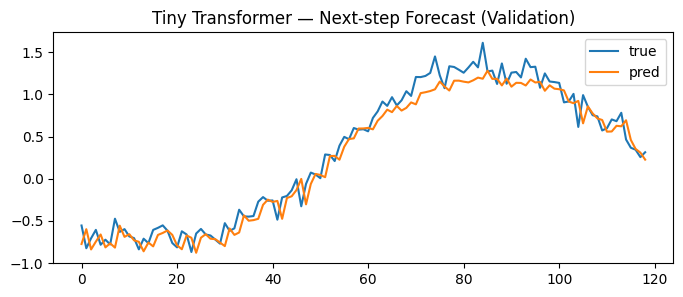

In [6]:
# Visualize validation predictions
y_pred_val = predict(model_tiny, X_val_sc)
plot_series(y_val.squeeze(), y_pred_val.squeeze(), title="Tiny Transformer — Next-step Forecast (Validation)")

## 2) Single-Site Weather Variable (MetPy) — Slightly Larger Transformer

We extract a **temperature** series at one grid point from MetPy's sample NARR file,
build sliding windows, and fit a small Transformer with `d_model=32`, `nhead=2`, `num_layers=1`.

In [7]:
import xarray as xr
from metpy.cbook import get_test_data
from metpy.units import units

# Load NARR sample file (downloads if missing)
path = get_test_data('narr_example.nc', as_file_obj=False)
ds = xr.open_dataset(path).metpy.parse_cf()

# Pick temperature (isobaric) and a grid point
varname = "Temperature_isobaric"
assert varname in ds.variables, "Expected 'Temperature_isobaric' not found. Explore ds to select another variable."
temp = ds[varname]  # (time, isobaric, y, x)

# Choose one level and grid point
temp_point = temp.isel(isobaric=0, y=20, x=20).metpy.convert_units('degC')
series_w = temp_point.values.astype(np.float32).reshape(-1, 1)

seq_len = 12
Xw, yw = make_sequences(series_w, seq_len=seq_len, target_horizon=1, target_cols=[0])

Xw_tr, Xw_val, yw_tr, yw_val = train_test_split(Xw, yw, test_size=0.25, shuffle=False)

# input scaling
scaler_w = StandardScaler().fit(Xw_tr.reshape(-1, Xw_tr.shape[-1]))
Xw_tr_sc = scaler_w.transform(Xw_tr.reshape(-1, Xw_tr.shape[-1])).reshape(Xw_tr.shape)
Xw_val_sc= scaler_w.transform(Xw_val.reshape(-1, Xw_val.shape[-1])).reshape(Xw_val.shape)

train_ds_w = SeqDataset(Xw_tr_sc, yw_tr)
val_ds_w   = SeqDataset(Xw_val_sc,  yw_val)
train_loader_w = DataLoader(train_ds_w, batch_size=64, shuffle=True)
val_loader_w   = DataLoader(val_ds_w,   batch_size=64)

model_w = TransformerForecaster(input_size=1, d_model=32, nhead=2, num_layers=1, dim_ff=64, dropout=0.1, output_size=1).to(DEVICE)
opt_w = torch.optim.Adam(model_w.parameters(), lr=1e-3)
crit_w = nn.MSELoss()

EPOCHS = 20
hist_w = {"train": [], "val": []}
for ep in range(EPOCHS):
    tr = train_epoch(model_w, train_loader_w, crit_w, opt_w)
    va = eval_epoch(model_w, val_loader_w, crit_w)
    hist_w["train"].append(tr)
    hist_w["val"].append(va)

print(f"Single-var Transformer — Final MSE: Train={hist_w['train'][-1]:.4f}, Val={hist_w['val'][-1]:.4f}")

AssertionError: Expected 'Temperature_isobaric' not found. Explore ds to select another variable.

In [ ]:
# Visualize validation predictions on MetPy temperature
y_pred_w = predict(model_w, Xw_val_sc)
plot_series(yw_val.squeeze(), y_pred_w.squeeze(), title="MetPy Temperature — Transformer Validation")

## 3) Multivariate, Multi-Head Transformer on MetPy

We now include **multiple variables** from the same site (grid point), e.g.:
- Temperature (degC) at a chosen isobaric level
- Geopotential height (gpm) at the same level (if available)
- U/V wind components at the same level (if available)

Inputs are multi-feature sequences; the model uses **multi-head attention** (`nhead=4`) and a deeper encoder.
The target remains the **next-step temperature** for clarity.

In [ ]:
# Collect multiple variables if present; gracefully fall back if missing
features = []

# Temperature (must exist)
temp0 = ds['Temperature_isobaric'].isel(isobaric=0, y=20, x=20).metpy.convert_units('degC').values.astype(np.float32)
features.append(temp0)

# Try geopotential height
if 'Geopotential_height_isobaric' in ds.variables:
    hgt0 = ds['Geopotential_height_isobaric'].isel(isobaric=0, y=20, x=20).values.astype(np.float32)
    features.append(hgt0)
# Try u/v wind
if 'u-component_of_wind_isobaric' in ds.variables:
    u0 = ds['u-component_of_wind_isobaric'].isel(isobaric=0, y=20, x=20).values.astype(np.float32)
    features.append(u0)
if 'v-component_of_wind_isobaric' in ds.variables:
    v0 = ds['v-component_of_wind_isobaric'].isel(isobaric=0, y=20, x=20).values.astype(np.float32)
    features.append(v0)

# Stack features: shape (T, F)
multi_X = np.stack(features, axis=1)
target_cols = [0]  # predict temperature next step

seq_len_m = 12
Xm, ym = make_sequences(multi_X, seq_len=seq_len_m, target_horizon=1, target_cols=target_cols)

Xm_tr, Xm_val, ym_tr, ym_val = train_test_split(Xm, ym, test_size=0.25, shuffle=False)

# scale inputs only
scaler_m = StandardScaler().fit(Xm_tr.reshape(-1, Xm_tr.shape[-1]))
Xm_tr_sc = scaler_m.transform(Xm_tr.reshape(-1, Xm_tr.shape[-1])).reshape(Xm_tr.shape)
Xm_val_sc= scaler_m.transform(Xm_val.reshape(-1, Xm_val.shape[-1])).reshape(Xm_val.shape)

train_ds_m = SeqDataset(Xm_tr_sc, ym_tr)
val_ds_m   = SeqDataset(Xm_val_sc,  ym_val)
train_loader_m = DataLoader(train_ds_m, batch_size=64, shuffle=True)
val_loader_m   = DataLoader(val_ds_m,   batch_size=64)

input_size_m = Xm_tr_sc.shape[2]

# Multi-head, deeper encoder
model_m = TransformerForecaster(
    input_size=input_size_m,
    d_model=64,
    nhead=4,
    num_layers=2,
    dim_ff=128,
    dropout=0.1,
    output_size=1
).to(DEVICE)

opt_m = torch.optim.Adam(model_m.parameters(), lr=1e-3)
crit_m = nn.MSELoss()

EPOCHS = 25
hist_m = {"train": [], "val": []}
for ep in range(EPOCHS):
    tr = train_epoch(model_m, train_loader_m, crit_m, opt_m)
    va = eval_epoch(model_m, val_loader_m, crit_m)
    hist_m["train"].append(tr)
    hist_m["val"].append(va)

print(f"Multivariate Transformer — Final MSE: Train={hist_m['train'][-1]:.4f}, Val={hist_m['val'][-1]:.4f}")

In [ ]:
# Plot predictions vs truth
y_pred_m = predict(model_m, Xm_val_sc)
plot_series(ym_val.squeeze(), y_pred_m.squeeze(), title="Multivariate Transformer (nhead=4) — Validation")

### Wrap-up & Ideas to Extend

- Try longer windows, multistep horizons (predict t+1..t+H), or multi-target outputs.
- Add exogenous variables (e.g., pressure, humidity) and calendar/diurnal encodings.
- Use learning rate schedulers, early stopping, and weight decay.
- Scale up model capacity or train longer on GPU for improved accuracy.